# RAFT Fine-tuning

Downloading RAFT from it's repository

In [ ]:
!git clone https://github.com/princeton-vl/RAFT.git

%cd RAFT
!./download_models.sh
%cd ..

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 3 (delta 0), pack-reused 144 (from 1)
Receiving objects: 100% (147/147), 10.01 MiB | 28.57 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/RAFT
--2024-11-26 09:19:55--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  41.7MB/s    in 1.9s    

2024-11-26 09:19:58 (41.7 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflatin

In [ ]:
import sys
import os
sys.path.append('RAFT/core')

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path, args):
    """ Loads model to CUDA only """
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device(device=device))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to(device)
    return model

We import a subset of the dataset (~~≃ 2000 images~~ 800 images, one of the images is corrupted due to the compression)

In [ ]:
img_folder = '/pathtoyourimagefolder'  # Path to your image folder
images = sorted(os.listdir(img_folder))  # List and sort images

We define a custom dataset class to create pairs of frame

In [ ]:
class BirdDataset(Dataset):

  def __init__(self, images_path, transform=None):
    self.images_path = images_path
    self.images = [f for f in sorted(os.listdir(img_folder)) if f.endswith('.jpg')][:100]
    self.transform = transform

  def __len__(self):
    return len(self.images) - 1 # Pair of images

  def __getitem__(self, idx):
    img1_path = os.path.join(self.images_path, self.images[idx])
    img2_path = os.path.join(self.images_path, self.images[idx + 1])

    img1 = Image.open(img1_path).convert('RGB')
    img2 = Image.open(img2_path).convert('RGB')

    img1 = np.array(img1).transpose(2, 0, 1)
    img2 = np.array(img2).transpose(2, 0, 1)

    img1 = torch.tensor(np.array(img1))
    img2 = torch.tensor(np.array(img2))

    if self.transform:
          img1 = self.transform(img1)
          img2 = self.transform(img2)

    return img1, img2

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((600, 600))
])

We create a dataset instance and test it

In [ ]:
dataset = BirdDataset(img_folder, transform=transform)

# Check the length of the dataset
print(f"Dataset size: {len(dataset)}")

# Check the first item
img1, img2 = dataset[0]
print(f"First image pair shapes: {img1.shape}, {img2.shape}")

Dataset size: 99
First image pair shapes: torch.Size([3, 600, 600]), torch.Size([3, 600, 600])


Same with a dataloader

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

In [ ]:
for i, (img1, img2) in enumerate(dataloader):
    print(f"Batch {i + 1}:")
    print(f"Image 1: {dataset.images[i * 8]}")
    print(f"Image 2: {dataset.images[i * 8 + 1]}")
    print(img1.shape, img2.shape)
    if i == 0:
        break  # Check only the first batch


Batch 1:
Image 1: sequence=100_video-20220514_053015-01_frame=285.jpg
Image 2: sequence=100_video-20220514_053015-01_frame=286.jpg
torch.Size([8, 3, 600, 600]) torch.Size([8, 3, 600, 600])


In [ ]:
# class to interface with RAFT
class Args():
  def __init__(self, model='', path='', small=True,
               mixed_precision=False, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration


model = load_model("RAFT/models/raft-small.pth", args=Args())

<ipython-input-3-79cf122e368c>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(weights_path, map_location=torch.device(device=device))


We create a custom loss function to fine-tune raft in a unsupervised manner

In [ ]:
import torch.nn as nn
from torch.optim import Adam

#backwarp_tenGrid = {}

import torch
import torch.nn.functional as F

def warp(x, flo):
    B, C, H, W = x.size()

    # Mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()

    # Add flow to grid
    vgrid = grid + flo

    # Scale grid to [-1, 1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    # Convert tensors to float32 before grid_sample
    vgrid = vgrid.permute(0, 2, 3, 1).float()  # Ensure grid is float
    x = x.float()  # Ensure input is float

    # Warp image
    output = F.grid_sample(x, vgrid, mode='bilinear', padding_mode='zeros', align_corners=True)

    # Create mask for valid regions
    mask = torch.ones(x.size(), device=x.device).float()  # Mask must also be float
    mask = F.grid_sample(mask, vgrid, mode='bilinear', padding_mode='zeros', align_corners=True)
    mask[mask < 0.9999] = 0
    mask[mask >= 0.9999] = 1

    return output * mask




class PhotometricLoss(nn.Module):
  def __init__ (self):
    super(PhotometricLoss, self).__init__()

  def forward(self, I1, I2, flow):
      warped_I2 = warp(I2, flow)
      loss = torch.abs(I1 - warped_I2)
      return loss.mean()


optimizer = Adam(params=model.parameters(), lr=0.01)
loss_fn = PhotometricLoss()



In [ ]:
model.train()

DataParallel(
  (module): RAFT(
    (fnet): SmallEncoder(
      (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): BottleneckBlock(
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): BottleneckBlock(
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 

Training Loop

In [ ]:
num_epochs = 2

for epoch in range(num_epochs + 1):

  for img1, img2 in dataloader:

    img1, img2 = img1.to(device), img2.to(device)

    flow = model(img1, img2)
    loss = loss_fn(img1, img2, flow[-1])

    optimizer.step()
    loss.backward()
    optimizer.zero_grad()
    print("Loss: %f" % float(loss))
  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


Loss: 2.003633
Loss: 2.081600
Loss: 1.917090
Loss: 2.000638
Loss: 1.944463
Loss: 1.982861
Loss: 1.987557
Loss: 2.647637
Loss: 1.937530
Loss: 1.983526
Loss: 1.922563
Loss: 2.073745
Loss: 2.028797
Epoch: 0, Loss: 2.028797
Loss: 2.003633
Loss: 2.081600
Loss: 1.917090
Loss: 2.000638
Loss: 1.944463
Loss: 1.982861
Loss: 1.987557
Loss: 2.647637
Loss: 1.937530
Loss: 1.983526
Loss: 1.922563
Loss: 2.073745
Loss: 2.028797
Epoch: 1, Loss: 2.028797
Loss: 2.003633
Loss: 2.081600
Loss: 1.917090
Loss: 2.000638
Loss: 1.944463
Loss: 1.982861
Loss: 1.987557
Loss: 2.647637
Loss: 1.937530
Loss: 1.983526
Loss: 1.922563
Loss: 2.073745
Loss: 2.028797
Epoch: 2, Loss: 2.028797


The loss does not decrease, it could be due to a wrong definition of the loss function or the fact that a lot of information is loss when resizing the images

In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
model.eval()

DataParallel(
  (module): RAFT(
    (fnet): SmallEncoder(
      (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): BottleneckBlock(
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): BottleneckBlock(
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 

In [ ]:
def get_flow_viz(flow):
    # Check if the input is 4D and extract the first batch
    if flow.ndimension() == 4:
        flow = flow[0]  # Extract the first batch

    # Convert PyTorch tensor to NumPy array (detach from the graph)
    flow_np = flow.permute(1, 2, 0).detach().cpu().numpy()  # Convert to [H, W, 2] format

    # Split flow into x and y components
    flow_x, flow_y = flow_np[..., 0], flow_np[..., 1]

    # Compute magnitude and angle of flow
    mag, ang = cv2.cartToPolar(flow_x, flow_y)

    # Create HSV image
    hsv = np.zeros((flow_np.shape[0], flow_np.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Angle in degrees
    hsv[..., 1] = 255  # Full saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Normalize magnitude

    # Convert HSV to BGR for visualization
    flow_viz = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return flow_viz, mag




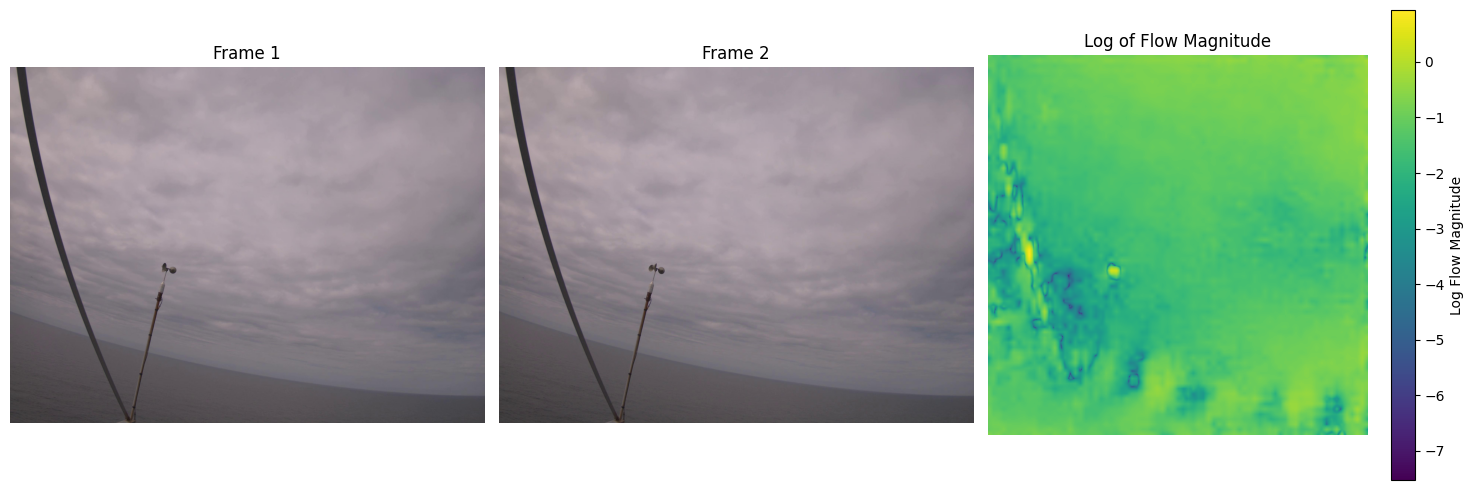

In [ ]:
image_path1 = '/test_frame1.jpg'
image_path2 = '/test_frame2.jpg'
frame1 = cv2.imread(image_path1)
frame2 = cv2.imread(image_path2)

frame1_tensor = torch.from_numpy(frame1).permute(2, 0, 1).float().to(device)  # HWC to CHW
frame2_tensor = torch.from_numpy(frame2).permute(2, 0, 1).float().to(device)

transformed_frame1 = transform(frame1_tensor)
transformed_frame2 = transform(frame2_tensor)

transformed_frame1 = transformed_frame1.unsqueeze(0)  # Shape: [1, 3, 224, 224]
transformed_frame2 = transformed_frame2.unsqueeze(0)  # Shape: [1, 3, 224, 224]

# Compute optical flow
flow = model(transformed_frame1, transformed_frame2)

# Get flow visualization and magnitude
flow_viz, mag = get_flow_viz(flow[-1])

# Compute log of the magnitude (adding a small constant to avoid log(0))
log_mag = np.log(mag + 1e-8)

# Plot the results
plt.figure(figsize=(15, 5))

# Display the first frame
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title("Frame 1")
plt.axis("off")

# Display the second frame
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title("Frame 2")
plt.axis("off")

# Display the log of the flow magnitude
plt.subplot(1, 3, 3)
plt.imshow(log_mag, cmap="viridis")
plt.colorbar(label="Log Flow Magnitude")
plt.title("Log of Flow Magnitude")
plt.axis("off")

plt.tight_layout()
plt.show()